In [1]:
import requests
import pandas as pd
import time
import sqlite3
import datetime
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

## hellocycling情報を取得

In [2]:
url = "https://www.hellocycling.jp/app/top/port_json?data=data"

try:
    response = requests.get(url)

    response.raise_for_status()

    data = response.json()

    df = pd.DataFrame.from_dict(data, orient='index')

    print("\n columnを取得:")
    print(df.columns)

except Exception as e:
    print(f"エラーが発生しました: {e}")


 columnを取得:
Index(['id', 'isopen', 'name', 'port', 'company', 'site_url', 'address',
       'type', 'possible', 'company_icon', 'tel', 'lat', 'lng',
       'num_bikes_parkable', 'num_bikes_now', 'num_bikes_rentalable',
       'num_bikes_limit', 'battery_flag', 'port_photo_path', 'port_icon_path',
       'icon', 'modal_type', 'description_title', 'description',
       'external_url', 'category_icon', 'port_name', 'icon_size_w',
       'icon_size_h', 'icon_posi_w', 'icon_posi_h', 'bike_list',
       'port_admin_url', 'port_company_id', 'business_hour'],
      dtype='object')


## 文京区のデータを取得

In [4]:
try:
    response = requests.get(url)

    response.raise_for_status()
    data = response.json()

    df = pd.DataFrame.from_dict(data, orient='index')

    target_column = ['id', 'name', 'address', 'lat', 'lng']

    df_bunnkyou = df[df['address'].str.contains('文京区')]

    df_result = df_bunnkyou[target_column].copy()

    print("\n 文京区の住所を取得:")
    print(df_result)


except Exception as e:
    print(f"エラーが発生しました: {e}")


 文京区の住所を取得:
          id             name           address                   lat  \
6788    6788     ガリシアグランデ江戸川橋    東京都文京区水道2-5-17  35.70987100000000000   
6791    6791    SANパーク 文京本駒込4   東京都文京区本駒込4-46-1  35.73376100000000000   
10144  10144    HAKUSAN HOUSE  東京都文京区白山 4-33-14  35.72031520103726000   
12080  12080          目白台運動公園     東京都文京区目白台1-19  35.71571500000000000   
12120  12120        千石南自転車駐車場   東京都文京区白山5-17-13  35.72702100000000000   
12575  12575           大塚窪町公園      東京都文京区大塚3-28  35.72221100000000000   
12576  12576           教育の森公園   東京都文京区大塚３丁目１７−８  35.72084900000000000   
13715  13715          アジア文化会館  東京都文京区本駒込2-12-13  35.72924000000000000   
13716  13716             宮下公園   東京都文京区千石４丁目２３−１  35.72965000000000000   
14144  14144        ブルービルディング   東京都文京区本郷2丁目19-7  35.70517600000000000   
14210  14210  江戸川橋ステーションレジデンス    東京都文京区関口1-44-8  35.70943360000000000   
14454  14454     春日自転車駐車場（地下）     東京都文京区春日１丁目１６  35.70831475400240000   
14770  14770     ヴィラ・KITAGAWA   東京都文京区

## 国土地理院のAPIを使用して文京区の標高を検索

In [5]:
# latとlngを数値に変換します（エラーがある場合はNaNになります）
df_result['lat'] = pd.to_numeric(df_result['lat'], errors='coerce')
df_result['lng'] = pd.to_numeric(df_result['lng'], errors='coerce')

# 国土地理院のAPIから標高を取得する関数
def get_elevation(row):
    print(f"取得中：{row['name']}")

    lat = row['lat']
    lng = row['lng']

    try:
        # 国土地理院のAPI URL
        url = f"https://cyberjapandata2.gsi.go.jp/general/dem/scripts/getelevation.php?lon={lng}&lat={lat}&outtype=JSON"
        response = requests.get(url, timeout=5)
        data = response.json()
        
        # 標高データを取り出す
        elevation = data.get('elevation')
        
        # サーバーに負荷をかけないよう少し待機
        time.sleep(0.1) 
        
        return elevation
    except:
        return None

print("標高データの取得を開始します...（ポート数によっては時間がかかります）")

# 文京区に絞り込んだデータフレーム(df)に対して実行
# 新しい列 'elevation' を作ります
df_result['elevation'] = df_result.apply(get_elevation, axis=1)

# 結果の確認
print(df_result[['name', 'lat', 'lng', 'elevation']])


標高データの取得を開始します...（ポート数によっては時間がかかります）
取得中：ガリシアグランデ江戸川橋
取得中：SANパーク 文京本駒込4
取得中：HAKUSAN HOUSE
取得中：目白台運動公園
取得中：千石南自転車駐車場
取得中：大塚窪町公園
取得中：教育の森公園
取得中：アジア文化会館
取得中：宮下公園
取得中：ブルービルディング
取得中：江戸川橋ステーションレジデンス
取得中：春日自転車駐車場（地下）
取得中：ヴィラ・KITAGAWA
取得中：ロアール小石川植物園
取得中：ロアール御茶ノ水順天堂大学前
取得中：千石4丁目
取得中：関口1丁目
取得中：湯島３丁目
取得中：文京区大塚6丁目個人宅駐車場
                  name        lat         lng  elevation
6788      ガリシアグランデ江戸川橋  35.709871  139.737012        5.2
6791     SANパーク 文京本駒込4  35.733761  139.755865       10.1
10144    HAKUSAN HOUSE  35.720315  139.749809       16.6
12080          目白台運動公園  35.715715  139.721448       28.6
12120        千石南自転車駐車場  35.727021  139.746115       22.4
12575           大塚窪町公園  35.722211  139.736370       16.8
12576           教育の森公園  35.720849  139.735476       22.9
13715          アジア文化会館  35.729240  139.747953       23.3
13716             宮下公園  35.729650  139.739278       25.0
14144        ブルービルディング  35.705176  139.758878       21.8
14210  江戸川橋ステーションレジデンス  35.709434  139.729219        5.2
14454 

## 標高別にジャンル分け

In [6]:
def judge_elevation(x):
    if x >= 20:
        return '高い'
    elif x >= 10:
        return '普通'
    else:
        return '低い'

df_result['area_type'] = df_result['elevation'].apply(judge_elevation)

# 各グループに何件ずつあるか確認
print(df_result[['name', 'elevation', 'area_type']])

                  name  elevation area_type
6788      ガリシアグランデ江戸川橋        5.2        低い
6791     SANパーク 文京本駒込4       10.1        普通
10144    HAKUSAN HOUSE       16.6        普通
12080          目白台運動公園       28.6        高い
12120        千石南自転車駐車場       22.4        高い
12575           大塚窪町公園       16.8        普通
12576           教育の森公園       22.9        高い
13715          アジア文化会館       23.3        高い
13716             宮下公園       25.0        高い
14144        ブルービルディング       21.8        高い
14210  江戸川橋ステーションレジデンス        5.2        低い
14454     春日自転車駐車場（地下）        6.5        低い
14770     ヴィラ・KITAGAWA        8.3        低い
16817       ロアール小石川植物園        9.7        低い
16900   ロアール御茶ノ水順天堂大学前       23.0        高い
23744            千石4丁目       24.4        高い
24492            関口1丁目        4.7        低い
24732            湯島３丁目        6.4        低い
24733   文京区大塚6丁目個人宅駐車場       30.4        高い


## マスターテーブル保存

In [6]:
db_name = "bunkyo_cycle.db"
conn = sqlite3.connect(db_name)
cursor = conn.cursor()

df_result.to_sql('port_master', conn, if_exists='replace', index=False)

print("マスターテーブル保存")
conn.close()

マスターテーブル保存


## 文京区のポートにある自転車の数を表示

In [7]:
try:
    response = requests.get(url)

    response.raise_for_status()
    data = response.json()

    df = pd.DataFrame.from_dict(data, orient='index')

    target_column = ['address', 'num_bikes_parkable', 'num_bikes_now', 'num_bikes_rentalable', 'num_bikes_limit']

    df_bunnkyou = df[df['address'].str.contains('文京区')]

    print("\n現在の貸出状況（文京区）")
    print(df_bunnkyou[target_column])

except Exception as e:
    print(f"エラーが発生しました:{e}")


現在の貸出状況（文京区）
                address  num_bikes_parkable  num_bikes_now  \
6788     東京都文京区水道2-5-17                   2              3   
6791    東京都文京区本駒込4-46-1                   1              3   
10144  東京都文京区白山 4-33-14                   2              4   
12080     東京都文京区目白台1-19                   5              7   
12120   東京都文京区白山5-17-13                   7              2   
12575      東京都文京区大塚3-28                   0              2   
12576   東京都文京区大塚３丁目１７−８                   0              6   
13715  東京都文京区本駒込2-12-13                   1              6   
13716   東京都文京区千石４丁目２３−１                   3              1   
14144   東京都文京区本郷2丁目19-7                   1              1   
14210    東京都文京区関口1-44-8                   2              1   
14454     東京都文京区春日１丁目１６                   2             10   
14770   東京都文京区白山１－１４－１５                  10             15   
16817  東京都文京区小石川５丁目３１−７                   0              6   
16900    東京都文京区本郷2-14-8                   1             

## 実際に15分おきに変化があるかを確かめる

In [ ]:
interval_minutes = 15 * 60

while True:
    try:
        response = requests.get(url)

        response.raise_for_status()
        data = response.json()
        df = pd.DataFrame.from_dict(data, orient='index')
        
        

        now = datetime.datetime.now()
        

        df_bunnkyou = df[df['address'].str.contains('文京区')].copy()


        target_columns = ['id', 'address', 'num_bikes_parkable', 'num_bikes_now', 'num_bikes_rentalable', 'num_bikes_limit', 'timestamp']

        df_bunnkyou['timestamp'] = now.strftime("%Y-%m-%d %H:%M:%S")

        
        db_name = "cycele_status_bunkyo_morning.db"
        conn = sqlite3.connect(db_name)
        df_bunnkyou[target_columns].to_sql('cycle_status', conn, if_exists='append', index=False)
        conn.close()

        print("\n現在の貸出状況（文京区）")
        print(df_bunnkyou[target_column])
        print(f"\n{interval_minutes/60}分経過しました。再度データを取得します。")
    
    except Exception as e:
        print(f"エラーが発生しました:{e}")

    time.sleep(interval_minutes)


現在の貸出状況（文京区）
                address  num_bikes_parkable  num_bikes_now  \
6788     東京都文京区水道2-5-17                   2              3   
6791    東京都文京区本駒込4-46-1                   1              3   
10144  東京都文京区白山 4-33-14                   2              4   
12080     東京都文京区目白台1-19                   5              7   
12120   東京都文京区白山5-17-13                   7              2   
12575      東京都文京区大塚3-28                   0              2   
12576   東京都文京区大塚３丁目１７−８                   0              6   
13715  東京都文京区本駒込2-12-13                   1              6   
13716   東京都文京区千石４丁目２３−１                   3              1   
14144   東京都文京区本郷2丁目19-7                   1              1   
14210    東京都文京区関口1-44-8                   2              1   
14454     東京都文京区春日１丁目１６                   2             10   
14770   東京都文京区白山１－１４－１５                  10             15   
16817  東京都文京区小石川５丁目３１−７                   0              6   
16900    東京都文京区本郷2-14-8                   1             

KeyboardInterrupt: 

## マスターテーブルを取得したテーブルを繋げ合わせる

In [3]:
# 1. データベースからそれぞれのテーブルを読み込む
conn1 = sqlite3.connect("cycele_status_bunkyo.db")
df_log = pd.read_sql("SELECT * FROM cycle_status", conn1)
conn1.close()

conn2 = sqlite3.connect("bunkyo_cycle.db")
df_master = pd.read_sql("SELECT * FROM port_master", conn2)
conn2.close()


# ログデータ(df_log)に、マスタデータ(df_master)の情報を付け加えるイメージ
df_merged = pd.merge(
    df_log, 
    df_master[['id', 'name', 'elevation', 'area_type']], # マスタからは必要な列だけ選ぶとスッキリします
    on='id', 
    how='left'
)

# 3. 結果の確認
print("合体後のデータ（最初の5件）:")
print(df_merged.head())

df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'])

合体後のデータ（最初の5件）:
      id           address  num_bikes_parkable  num_bikes_now  \
0   6788    東京都文京区水道2-5-17                   0              5   
1   6791   東京都文京区本駒込4-46-1                   2              2   
2  10144  東京都文京区白山 4-33-14                   0              6   
3  12080     東京都文京区目白台1-19                   5              7   
4  12120   東京都文京区白山5-17-13                   1              8   

   num_bikes_rentalable  num_bikes_limit            timestamp           name  \
0                     5                5  2026-01-23 16:56:24   ガリシアグランデ江戸川橋   
1                     2                4  2026-01-23 16:56:24  SANパーク 文京本駒込4   
2                     5                6  2026-01-23 16:56:24  HAKUSAN HOUSE   
3                     7               12  2026-01-23 16:56:24        目白台運動公園   
4                     8                9  2026-01-23 16:56:24      千石南自転車駐車場   

   elevation area_type  
0        5.2        低い  
1       10.1        普通  
2       16.6        普通  
3       28.6

## グラフ作成

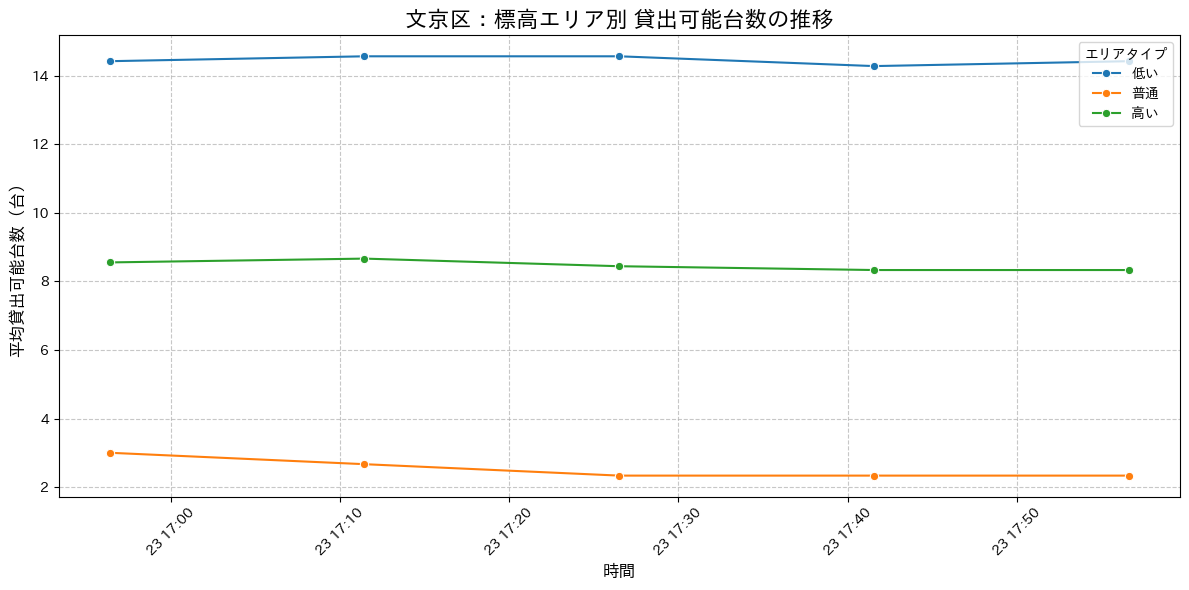

In [6]:
df_pivot = df_merged.groupby(['timestamp', 'area_type'])['num_bikes_rentalable'].mean().reset_index()

# --- グラフ作成 ---
plt.figure(figsize=(12, 6))

# # 日本語表示の設定（環境によって不要な場合や、'AppleGothic'などに変更が必要な場合があります）
# plt.rcParams['font.family'] = 'sans-serif'

# 折れ線グラフを描く（hue='area_type' で色分け）
sns.lineplot(data=df_pivot, x='timestamp', y='num_bikes_rentalable', hue='area_type', marker='o')

# グラフの見た目を整える
plt.title('文京区：標高エリア別 貸出可能台数の推移', fontsize=16)
plt.xlabel('時間', fontsize=12)
plt.ylabel('平均貸出可能台数（台）', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45) # 時間が見やすいように斜めにする
plt.legend(title='エリアタイプ')

plt.tight_layout()
plt.show()

In [10]:
# 1. データベースからそれぞれのテーブルを読み込む
conn1 = sqlite3.connect("cycele_status_bunkyo_morning.db")
df_log = pd.read_sql("SELECT * FROM cycle_status", conn1)
conn1.close()

conn2 = sqlite3.connect("bunkyo_cycle.db")
df_master = pd.read_sql("SELECT * FROM port_master", conn2)
conn2.close()


# ログデータ(df_log)に、マスタデータ(df_master)の情報を付け加えるイメージ
df_merged = pd.merge(
    df_log, 
    df_master[['id', 'name', 'elevation', 'area_type']], # マスタからは必要な列だけ選ぶとスッキリします
    on='id', 
    how='left'
)

# 3. 結果の確認
print("合体後のデータ（最初の5件）:")
print(df_merged.head())

df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'])

合体後のデータ（最初の5件）:
      id           address  num_bikes_parkable  num_bikes_now  \
0   6788    東京都文京区水道2-5-17                   2              3   
1   6791   東京都文京区本駒込4-46-1                   1              3   
2  10144  東京都文京区白山 4-33-14                   2              4   
3  12080     東京都文京区目白台1-19                   5              7   
4  12120   東京都文京区白山5-17-13                   7              2   

   num_bikes_rentalable  num_bikes_limit            timestamp           name  \
0                     3                5  2026-01-26 07:55:02   ガリシアグランデ江戸川橋   
1                     3                4  2026-01-26 07:55:02  SANパーク 文京本駒込4   
2                     4                6  2026-01-26 07:55:02  HAKUSAN HOUSE   
3                     7               12  2026-01-26 07:55:02        目白台運動公園   
4                     2                9  2026-01-26 07:55:02      千石南自転車駐車場   

   elevation area_type  
0        5.2        低い  
1       10.1        普通  
2       16.6        普通  
3       28.6

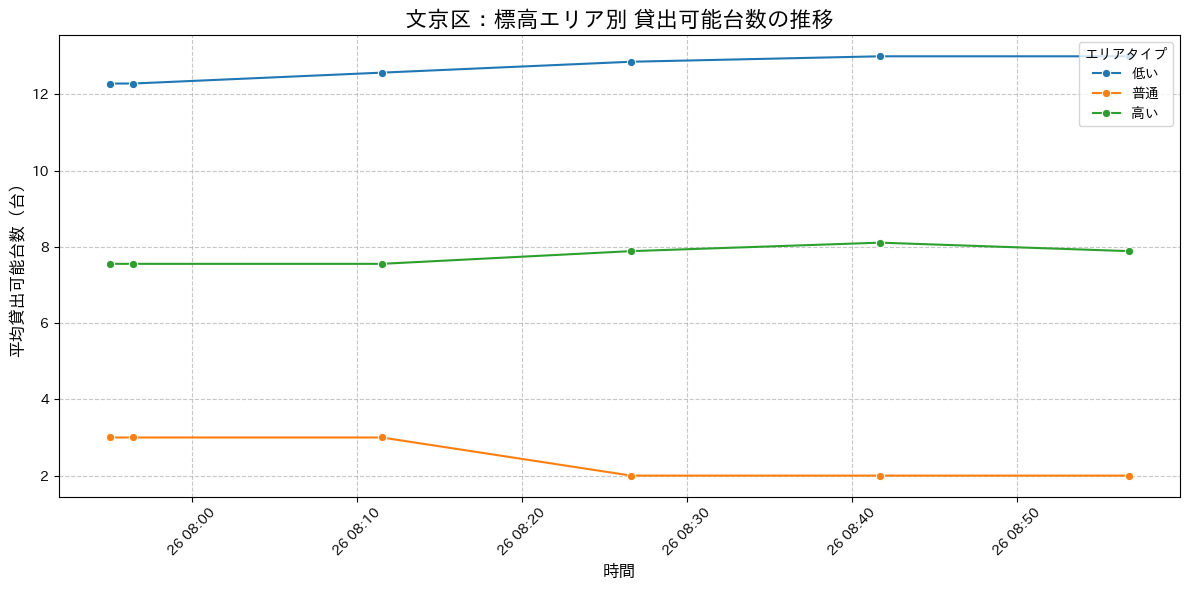

In [11]:
df_pivot = df_merged.groupby(['timestamp', 'area_type'])['num_bikes_rentalable'].mean().reset_index()

# --- グラフ作成 ---
plt.figure(figsize=(12, 6))

# # 日本語表示の設定（環境によって不要な場合や、'AppleGothic'などに変更が必要な場合があります）
# plt.rcParams['font.family'] = 'sans-serif'

# 折れ線グラフを描く（hue='area_type' で色分け）
sns.lineplot(data=df_pivot, x='timestamp', y='num_bikes_rentalable', hue='area_type', marker='o')

# グラフの見た目を整える
plt.title('文京区：標高エリア別 貸出可能台数の推移', fontsize=16)
plt.xlabel('時間', fontsize=12)
plt.ylabel('平均貸出可能台数（台）', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45) # 時間が見やすいように斜めにする
plt.legend(title='エリアタイプ')

plt.tight_layout()
plt.show()

In [18]:
interval_minutes = 15 * 60

start_time = "2026-01-26 19:00:00"
start_time_dt = datetime.datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")


while True:
    now = datetime.datetime.now()
    if now >= start_time_dt:
        print("指定した時間になった。")
        break

    difference = start_time_dt - now
    print(f"指定した時間まであと {difference} ")
    time.sleep(60)

while True:
        try:
            response = requests.get(url)

            response.raise_for_status()
            data = response.json()
            df = pd.DataFrame.from_dict(data, orient='index')
            
            

            now = datetime.datetime.now()
            

            df_bunnkyou = df[df['address'].str.contains('文京区')].copy()


            target_columns = ['id', 'address', 'num_bikes_parkable', 'num_bikes_now', 'num_bikes_rentalable', 'num_bikes_limit', 'timestamp']

            df_bunnkyou['timestamp'] = now.strftime("%Y-%m-%d %H:%M:%S")

            
            db_name = "cycele_status_bunkyo_night.db"
            conn = sqlite3.connect(db_name)
            df_bunnkyou[target_columns].to_sql('cycle_status', conn, if_exists='append', index=False)
            conn.close()

            print("\n現在の貸出状況（文京区）")
            print(df_bunnkyou[target_column])
            print(f"\n{interval_minutes/60}分経過しました。再度データを取得します。")
        
        except Exception as e:
            print(f"エラーが発生しました:{e}")

        time.sleep(interval_minutes)

    

指定した時間まであと 0:12:07.176918 
指定した時間まであと 0:11:07.171177 
指定した時間まであと 0:10:07.154443 
指定した時間まであと 0:09:07.148673 
指定した時間まであと 0:08:07.142313 
指定した時間まであと 0:07:07.140241 
指定した時間まであと 0:06:07.133643 
指定した時間まであと 0:05:07.126365 
指定した時間まであと 0:04:07.115930 
指定した時間まであと 0:03:07.108468 
指定した時間まであと 0:02:07.098582 
指定した時間まであと 0:01:07.095634 
指定した時間まであと 0:00:07.086251 
指定した時間になった。

現在の貸出状況（文京区）
                address  num_bikes_parkable  num_bikes_now  \
6788     東京都文京区水道2-5-17                   1              4   
6791    東京都文京区本駒込4-46-1                   4              0   
10144  東京都文京区白山 4-33-14                   2              4   
12080     東京都文京区目白台1-19                   6              6   
12120   東京都文京区白山5-17-13                   6              2   
12575      東京都文京区大塚3-28                   0              2   
12576   東京都文京区大塚３丁目１７−８                   0              6   
13715  東京都文京区本駒込2-12-13                   1              6   
13716   東京都文京区千石４丁目２３−１                   1              3   
141

KeyboardInterrupt: 

In [24]:
# 1. データベースからそれぞれのテーブルを読み込む
conn1 = sqlite3.connect("cycele_status_bunkyo_night.db")
df_log = pd.read_sql("SELECT * FROM cycle_status", conn1)
conn1.close()

conn2 = sqlite3.connect("bunkyo_cycle.db")
df_master = pd.read_sql("SELECT * FROM port_master", conn2)
conn2.close()


# ログデータ(df_log)に、マスタデータ(df_master)の情報を付け加えるイメージ
df_merged = pd.merge(
    df_log, 
    df_master[['id', 'name', 'elevation', 'area_type']], # マスタからは必要な列だけ選ぶとスッキリします
    on='id', 
    how='left'
)

# 3. 結果の確認
print("合体後のデータ（最初の5件）:")
print(df_merged.head())

df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'])

合体後のデータ（最初の5件）:
      id           address  num_bikes_parkable  num_bikes_now  \
0   6788    東京都文京区水道2-5-17                   1              4   
1   6791   東京都文京区本駒込4-46-1                   4              0   
2  10144  東京都文京区白山 4-33-14                   2              4   
3  12080     東京都文京区目白台1-19                   6              6   
4  12120   東京都文京区白山5-17-13                   6              2   

   num_bikes_rentalable  num_bikes_limit            timestamp           name  \
0                     4                5  2026-01-26 19:00:54   ガリシアグランデ江戸川橋   
1                     0                4  2026-01-26 19:00:54  SANパーク 文京本駒込4   
2                     4                6  2026-01-26 19:00:54  HAKUSAN HOUSE   
3                     6               12  2026-01-26 19:00:54        目白台運動公園   
4                     2                9  2026-01-26 19:00:54      千石南自転車駐車場   

   elevation area_type  
0        5.2        低い  
1       10.1        普通  
2       16.6        普通  
3       28.6

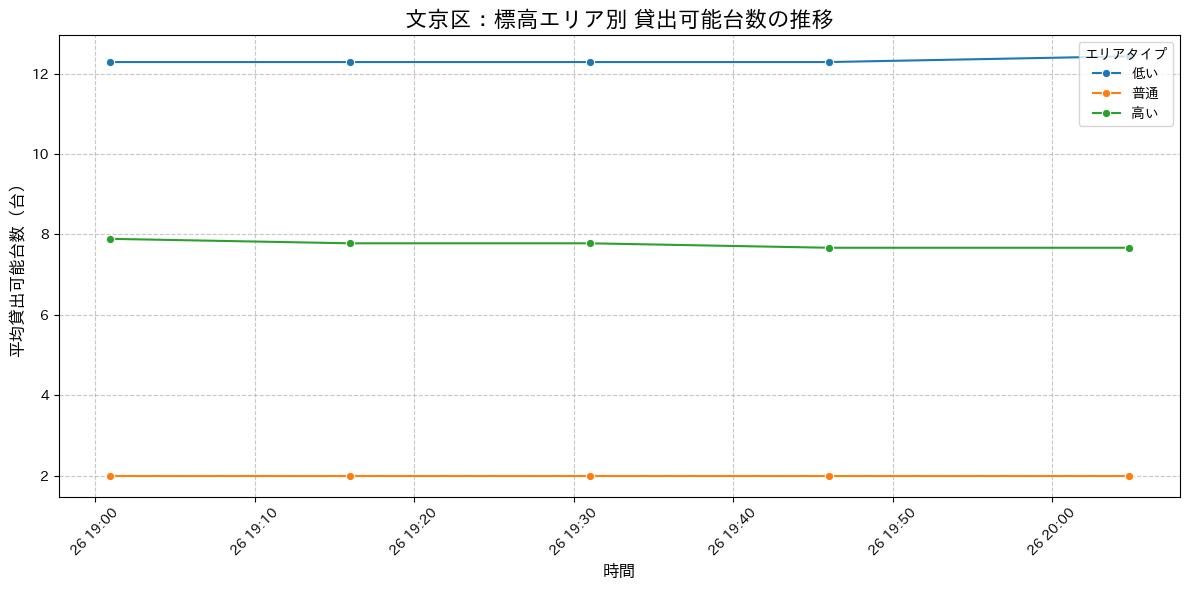

In [25]:
df_pivot = df_merged.groupby(['timestamp', 'area_type'])['num_bikes_rentalable'].mean().reset_index()

# --- グラフ作成 ---
plt.figure(figsize=(12, 6))

# # 日本語表示の設定（環境によって不要な場合や、'AppleGothic'などに変更が必要な場合があります）
# plt.rcParams['font.family'] = 'sans-serif'

# 折れ線グラフを描く（hue='area_type' で色分け）
sns.lineplot(data=df_pivot, x='timestamp', y='num_bikes_rentalable', hue='area_type', marker='o')

# グラフの見た目を整える
plt.title('文京区：標高エリア別 貸出可能台数の推移', fontsize=16)
plt.xlabel('時間', fontsize=12)
plt.ylabel('平均貸出可能台数（台）', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45) # 時間が見やすいように斜めにする
plt.legend(title='エリアタイプ')

plt.tight_layout()
plt.show()

In [22]:
conn = sqlite3.connect("cycele_status_bunkyo_night.db")

sql = "DELETE FROM cycle_status WHERE timestamp = '2026-01-26 14:46:58'"

conn.execute(sql)
conn.commit()
conn.close()